# Centro de Investigación e Innovación en Tecnologías de la Información y Comunicación


## presenta : José Miguel Hernández Pérez

# Usando modelos de aprendizaje supervisado par la Predicción del comportamiento del precio de una acción

# Introducción 

Uno de los grandes retos con los que se presentan los analistas de los mercados financieros es predecir o saber hacia a donde se moverá el precio de una acción o activo financiero, sin embargo, con los avances que se tienen en los modelos machine learning ha permitido al analista obtener predicciones con una mayor precisión, esto debido a que esto  modelos basan su predicción en datos históricos.

algunas de las variables utilizadas para predecir el precio de las acciones son las siguientes.

Activos correlacionados: las instituciones dependen e interactúan con una gran cantidad de factores, los cuales pueden ser, competidores, clientes, la economía global, la situación geopolítica, política fiscal y monetaria, etc. por lo tanto el precio de una acción no solo podría correlacionarse no solo con el precio de otra acción si no también con otros índices financieros, tipo de cambio de otro país, etc. 

Indicadores técnicos.
Análisis fundamentales: Reportes de empresas, noticias relevantes.

# 1. Definición del problema

En el presente caso utilizaremos varios modelos de aprendizaje supervisado para predecir el precio de las acciones de Microsoft utilizando activos correlacionados. Para seleccionar estos activos necesitamos entender que afecta el precio de Microsoft e intentar incorporar la mayor información posible dentro de nuestro modelo.


Para este caso de estudio utilizaremos las siguientes variables como independientes:

Acciones:
* IBM
* GOOGLE

Tipos de cambio

* USD/JPY 
* GBP/USD
  
índices
* S&P 500
* DOW Jones 
* VIX
  
Las series de datos de estas variables serán extraídas de yahoo finance y Federal Reserve Economic Data (Fred).



# 2 Carga de paqueteria

In [1]:
# Librerias de carga y transformación de datos
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler


#Funciones para evaluacion del modelo 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Funciones para modelos supervisados
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries para modelos Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Librerias para modelos estadisticos
import statsmodels.api as sm
from scipy import stats

#Libraririas para salvar el modelo
from pickle import dump
from pickle import load

# Librerias para modelos de series de tiempo

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Metricas de Error
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install yfinance
import yfinance as yf

  Preparing metadata (setup.py) ... - \ | / done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8498 sha256=640df645393f01004dace9867b0c1be897f79d0f2144a284f595d47065fba2c8
  Stored in directory: /home/datalore/.cache/pip/wheels/21/c9/66/b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


# 2.1 Carga de datos


Cargamos nuestras series de tiempo que serán la historia de los activos correlacionados que utilizaremos en el modelo

In [3]:
ticker_list = ['MSFT', 'IBM', 'GOOGL']
stk_data = yf.download(ticker_list,period="ld", start="2012-02-18",end="2022-02-18")

stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']


ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

[*********************100%***********************]  3 of 3 completed


A continuación, necesitamos una serie para predecir. Elegimos predecir usando retornos semanales, por lo que elegimos retornos de 5 días debido a que son los días que opera el mercado a la semana.

In [4]:
return_period = 5

Ahora definimos nuestra serie de datos Y y nuestra series X

* Y: MSFT retornos.
* X:
    a. GOOGL 5 Días de retornos
    b. IBM 5 Días de retornos    
    c. USD/JPY 5 Días de retornos    
    d. GBP/USD 5 Días de retornos    
    e. S&P 500 5 Días de retornos    
    f. Dow Jones 5 Días de retornos    
    g. MSFT 5 Días de retornos    
    h. MSFT 15 Días de retornos    
    i. MSFT 30 Días de retornos    
    j. MSFT 60 Días de retornos

In [5]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

# 3. Analisis Exploratorio (EDA)

# 3.1 Estadistica Descriptiva

In [6]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,221.000,221.000,2.210e+02,2.210e+02,2.210e+02,221.000,221.000,2.210e+02,221.000,221.000,221.000,221.000
mean,0.006,0.004,-3.348e-05,4.688e-04,-1.522e-04,0.003,0.002,8.164e-04,0.007,0.021,0.041,0.084
std,0.035,0.035,3.721e-02,8.901e-03,1.231e-02,0.026,0.027,1.767e-01,0.034,0.052,0.064,0.075
min,-0.179,-0.168,-2.312e-01,-3.313e-02,-7.267e-02,-0.198,-0.209,-4.953e-01,-0.179,-0.282,-0.229,-0.124
25%,-0.012,-0.014,-1.520e-02,-4.756e-03,-7.053e-03,-0.005,-0.006,-7.929e-02,-0.009,-0.002,0.009,0.046
50%,0.009,0.006,3.255e-03,8.831e-04,-5.636e-04,0.005,0.005,-9.205e-03,0.009,0.023,0.045,0.087
75%,0.026,0.025,1.695e-02,6.035e-03,6.804e-03,0.015,0.014,7.479e-02,0.026,0.049,0.083,0.131
max,0.090,0.124,1.178e-01,4.089e-02,4.258e-02,0.099,0.116,9.230e-01,0.090,0.156,0.264,0.377


Podemos observar las principales estadísticas de posición y dispersión en la tabla, como lo son la media, desviación estándar, y los percentiles de los retornos esperados de cada uno de nuestros activos correlacionados, así como el número de observaciones que tenemos dentro de nuestra tabla.

vemos como los activos en promedio han tenido un rendimiento cercano al cero y el activo que tiene una mayor desviación significaría que tiene un mayor riesgo ante las demás esto respecto a la teoría de los mercados financieros.

In [7]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-06-14,0.000,-0.034,1.857e-02,-0.003,-0.010,1.963e-03,0.009,0.024,-0.030,0.023,0.020,0.085
2017-06-21,-0.007,0.011,-1.300e-04,0.022,-0.011,-9.480e-04,0.002,0.010,0.000,0.006,0.023,0.082
2017-06-28,-0.018,-0.018,9.899e-03,0.005,0.021,2.084e-03,0.002,-0.069,-0.007,-0.036,0.006,0.069
2017-07-06,0.046,-0.035,-1.924e-02,0.009,-0.001,-4.121e-03,0.002,0.092,-0.018,-0.024,-0.002,0.051
2017-07-14,0.014,0.038,8.464e-03,-0.013,0.015,1.396e-02,0.010,-0.163,0.047,0.035,0.038,0.118


Visualizamos algunos valores de nuestros activos.

# 3.2 Visualización de datos

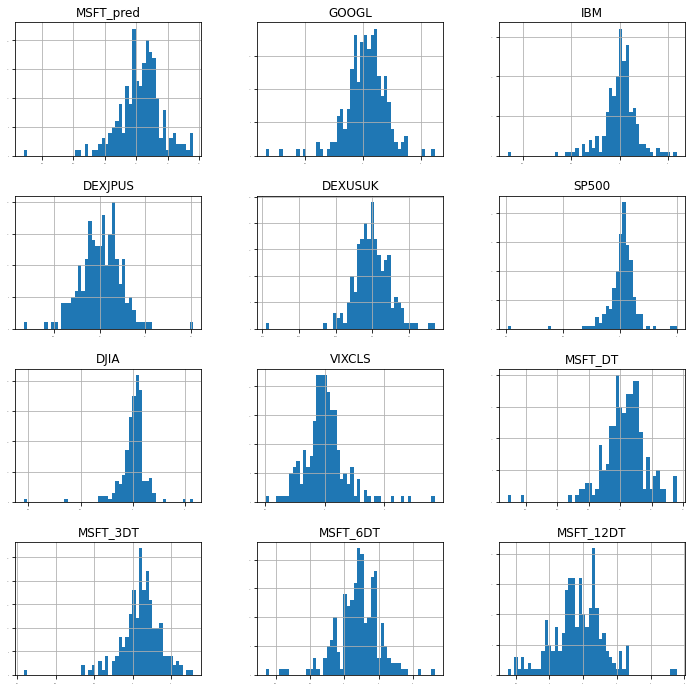

In [8]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

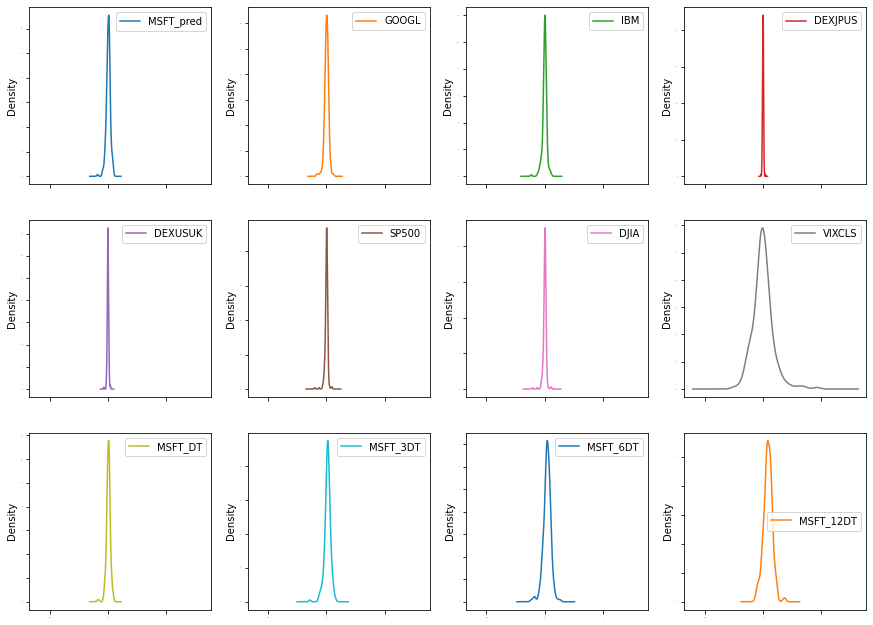

In [9]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Podemos ver que el vix tiene una varianza mucho mayor en comparación con las otras distribuciones.

Para tener una idea de la interdependencia de los datos, observamos el diagrama de dispersión y la matriz de correlación.

<AxesSubplot:title={'center':'Correlation Matrix'}>

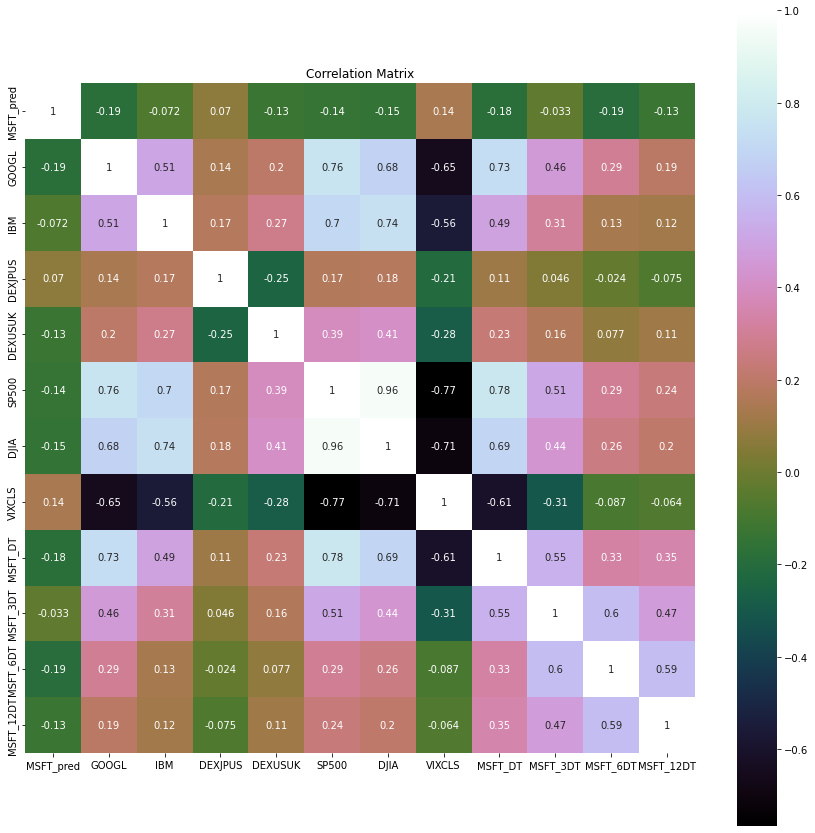

In [10]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

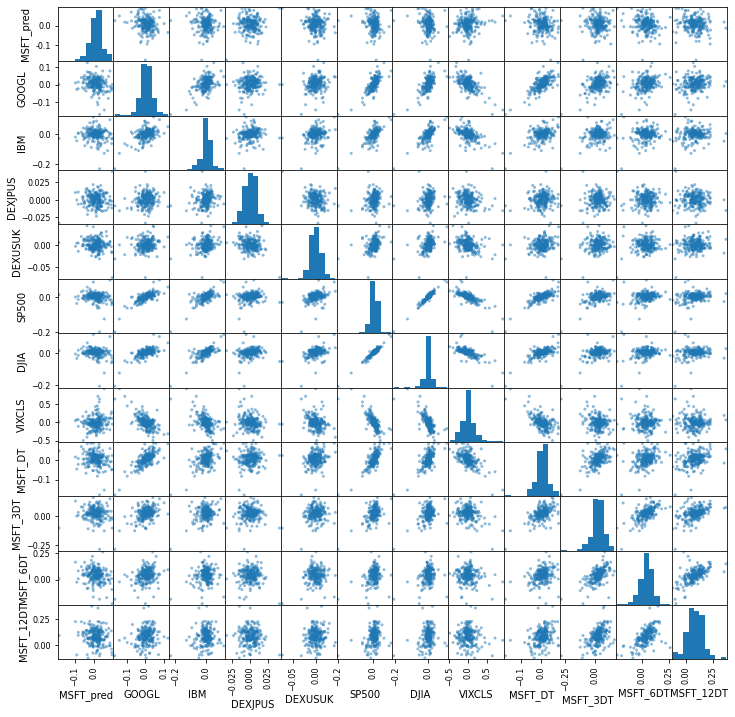

In [11]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Debido a las gráficas anteriores es notable que la mayoría de los activos con respecto al VIXCLS presentan una correlación negativa fuerte lo que quiere decir que los activos financieros se mueven en diferente dirección a dicho

# 4 Información de caracteristicas
## Información mutua 

In [12]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, Y, discrete_features = 'auto'):
    mi_scores = mutual_info_regression(X, Y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, Y)

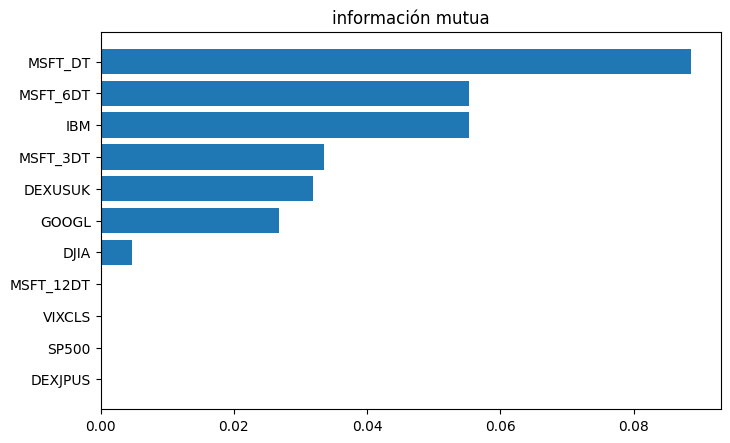

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("información mutua")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

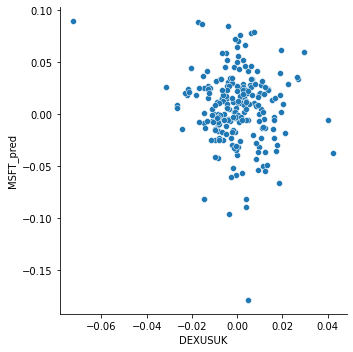

In [14]:
sns.relplot(x="DEXUSUK", y=Y, data=X);

In [15]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
featureScores.nlargest(10,'Score').set_index('Specs')  

,Score
Specs,
MSFT_6DT,8.183
GOOGL,7.819
MSFT_DT,7.336
DJIA,5.138
SP500,4.696
VIXCLS,4.593
MSFT_12DT,3.728
DEXUSUK,3.709
IBM,1.156


Analizando las características de mi conjunto de datos primero analizamos la información mutua entre las variables independientes con mi variable productora a lo que nuestro algoritmo nos arrojó que la variable con mayor información mutua era el tipo de cambio del dólar con la libra esterlina, después analizamos que variables tenían mayor importancia y cuales menor importancias para predecir el precio de la acción de Microsoft donde notamos que la propia variable de Microsoft con ciertas diferencias es al que mayor importancia tenía dentro de nuestro conjunto de datos, y siendo el indicé vix el que menor importancia tenia. 

## Descomposición de la serie de tiempo

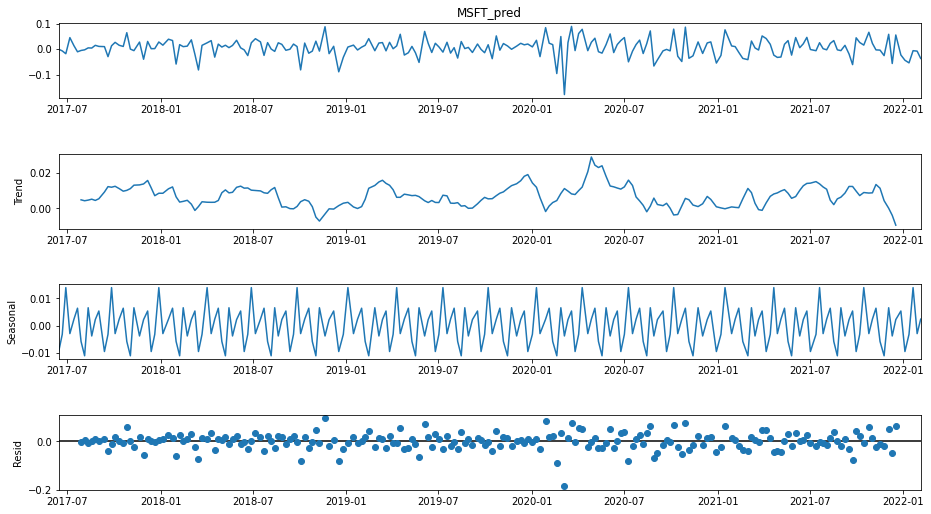

In [16]:

res = sm.tsa.seasonal_decompose(Y,model='additive', period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Podemos observar que la acción de Microsoft ha tenido una tendencia a la alza, sin embargo en el último año ha presentado una ligera bajada esto debido a los sucesos que están sucediendo mundialmente, por otro lado los residuos pareciera que tiene una desviación pequeña y se encuentran cercanos al 0 .

# 5 Evaluación del modelo

# División de los datos de entrenamiento y métricas de evaluación

A continuación, comenzamos dividiendo nuestros datos en 80% datos de entrenamiento y 20% datos de prueba.

En nuestro caso  los datos no dependan de la serie temporal, la división de entrenamiento y prueba se realiza en función de una muestra secuencial.

Esto lo hacemos  seleccionando un punto de división arbitrario en la lista ordenada de observaciones y creando dos nuevos conjuntos de datos.

In [17]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

# Opciones de prueba y métricas de evaluación

Evaluaremos los algoritmos utilizando media del error cuadrático, esta métrica nos da una idea de la evaluación del desempeño de los modelos de aprendizaje supervisado que someteremos a prueba, de igual manera utilizaremos 10 fold para poder obtener una mejor optimización en los hiperparametros de los modelos.

In [18]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' 

# Comparar modelos y algoritmos

Ahora que hemos cargado nuestros datos y definido nuestro conjunto de datos de análisis procederemos a escoger el mejor modelo para la predicción del precio de una acción.

**Regression and Tree Regression algorithms**


In [19]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

**Neural Network algorithms**

In [20]:
models.append(('MLP', MLPRegressor()))

 **Ensable Models** 

In [21]:

models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Una vez que hemos seleccionado todos los modelos, hacemos un loop sobre cada uno de ellos. Primero ejecutamos el análisis de K-fold. A continuación, ejecutamos el modelo en todos los datos de entrenamiento y prueba.

In [22]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)

    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    

    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001321 (0.000700) 0.001088 0.001043
LASSO: 0.001297 (0.000753) 0.001262 0.001016
EN: 0.001297 (0.000753) 0.001262 0.001016
KNN: 0.001446 (0.000800) 0.000931 0.001120
CART: 0.002274 (0.001134) 0.000000 0.001590
SVR: 0.002450 (0.000790) 0.002333 0.001989
MLP: 0.002695 (0.001482) 0.003034 0.002739
ABR: 0.001557 (0.000793) 0.000614 0.001015
GBR: 0.001612 (0.000799) 0.000077 0.001139
RFR: 0.001429 (0.000731) 0.000193 0.000937
ETR: 0.001477 (0.000698) 0.000000 0.000954


**K Fold results**

Veamos la comparación de los resultados de K-Fold

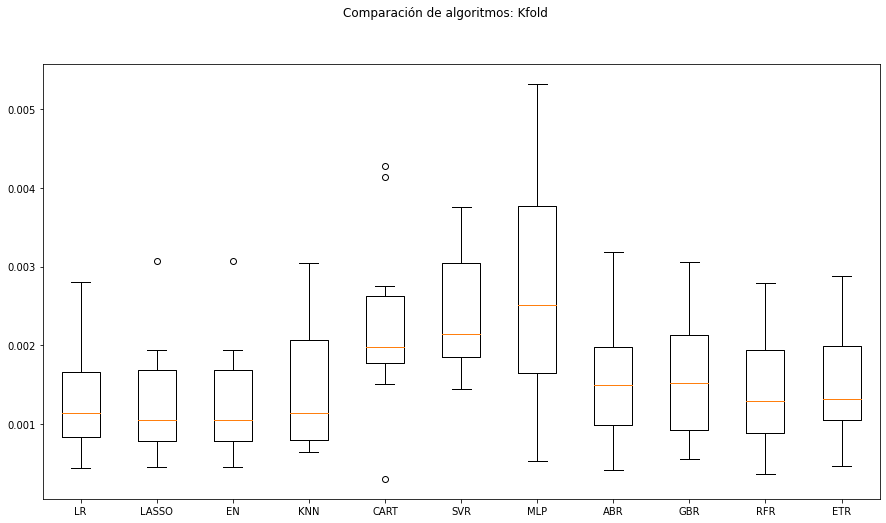

In [23]:
fig = pyplot.figure()
fig.suptitle('Comparación de algoritmos: Kfold ')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Observamos que los valores que tienen un mejor desempreño son lo svalores de regrsion lineal regular, Regresión Lasso , Y elastic net

Ahora veamos los errores en el conjunto de prueba 



# Comparativo de errores de conjunto de entramiento vs pruestas

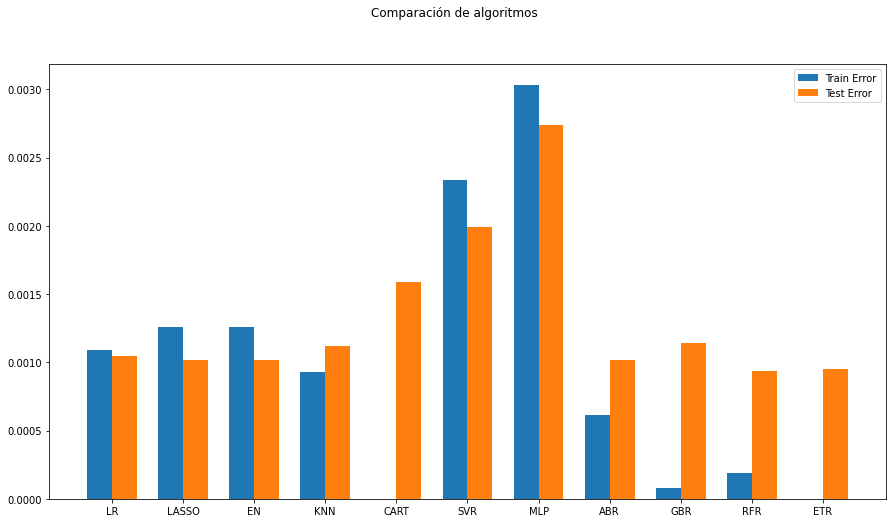

In [24]:

fig = pyplot.figure()

ind = np.arange(len(names))  
width = 0.35  

fig.suptitle('Comparación de algoritmos')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Comprobamos lo que veíamos anteriormente donde mencionábamos a los mejores modelos, aquí podemos ver como en algunos modelos existe un sobreajuste como en el modelo Cart y  ETR En los cuales no muestra errores en el conjunto de entrenamiento, el modelo MLP es el que presenta el mayor grado de error en ambos conjuntos de datos. 

Ahora aplicaremos 2 modelos base que son usados en series de tiempo como lo son el modelo Arima y un modelo de redes neuronales (LSTM)  y después lo compararemos con los modelos de machine learning evaluados.





# 6 Modelos base de Series Temporales -ARIMA y LSTM-


Arima

Primero preparemos el conjunto de datos para los modelos ARIMA, teniendo solo las variables correlacionadas como variables exógenas.

In [25]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)



## Aplicamos análisis de normalidad en las variables

ShapiroResult(statistic=0.9269324541091919, pvalue=9.591677496700868e-08)
Estadístico = 46.27124068285916, p-value = 8.960407281738371e-11


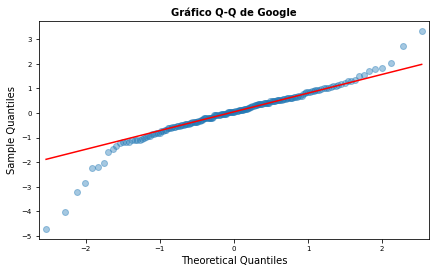

In [26]:
# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    X_train_ARIMA['GOOGL'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de Google', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

shapiro_test = stats.shapiro(X_train_ARIMA['GOOGL']    )
print(shapiro_test)


k2, p_value = stats.normaltest(X_train_ARIMA['GOOGL'])
print(f"Estadístico = {k2}, p-value = {p_value}")

ShapiroResult(statistic=0.88441002368927, pvalue=1.9805942996775627e-10)
Estadístico = 71.48705782913898, p-value = 2.9976617656984374e-16


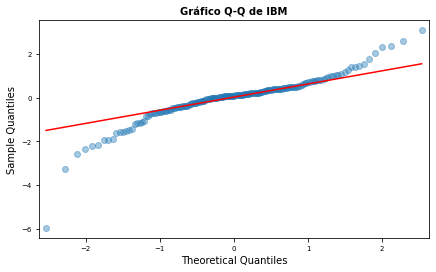

In [27]:
# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    X_train_ARIMA['IBM'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de IBM', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

shapiro_test = stats.shapiro(X_train_ARIMA['IBM']   )
print(shapiro_test)

k2, p_value = stats.normaltest(X_train_ARIMA['IBM'])
print(f"Estadístico = {k2}, p-value = {p_value}")

ShapiroResult(statistic=0.9735056757926941, pvalue=0.0019377147546038032)
Estadístico = 12.349176125827682, p-value = 0.002081663255148499


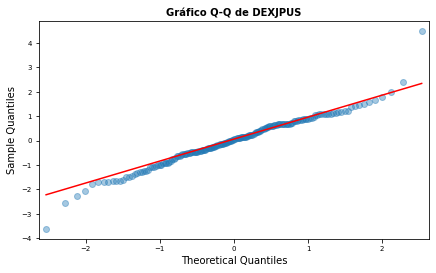

In [28]:
# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    X_train_ARIMA['DEXJPUS'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de DEXJPUS', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)


shapiro_test = stats.shapiro(X_train_ARIMA['DEXJPUS']   )
print(shapiro_test)

k2, p_value = stats.normaltest(X_train_ARIMA['DEXJPUS'])
print(f"Estadístico = {k2}, p-value = {p_value}")

ShapiroResult(statistic=0.7603048086166382, pvalue=1.1619506914392662e-15)
Estadístico = 138.50234172528363, p-value = 8.406178911767177e-31


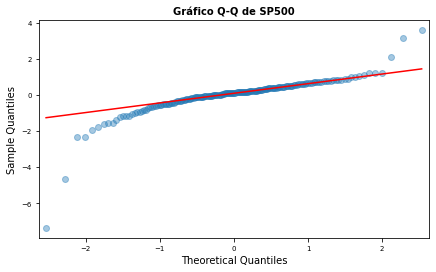

In [29]:
# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    X_train_ARIMA['SP500'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de SP500', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)



shapiro_test = stats.shapiro(X_train_ARIMA['SP500']   )
print(shapiro_test)

k2, p_value = stats.normaltest(X_train_ARIMA['SP500'])
print(f"Estadístico = {k2}, p-value = {p_value}")



ShapiroResult(statistic=0.7645610570907593, pvalue=1.6140803615411403e-15)
Estadístico = 124.78486041289024, p-value = 8.004087889738577e-28


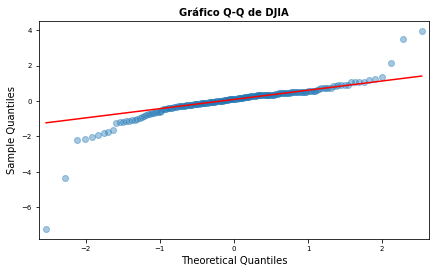

In [30]:
# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    X_train_ARIMA['DJIA'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de DJIA', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)


shapiro_test = stats.shapiro(X_train_ARIMA['DJIA']  )
print(shapiro_test)

k2, p_value = stats.normaltest(X_train_ARIMA['DJIA'])
print(f"Estadístico = {k2}, p-value = {p_value}")

ShapiroResult(statistic=0.9024072885513306, pvalue=2.1965684826597e-09)
Estadístico = 66.03793857177133, p-value = 4.571343339220196e-15


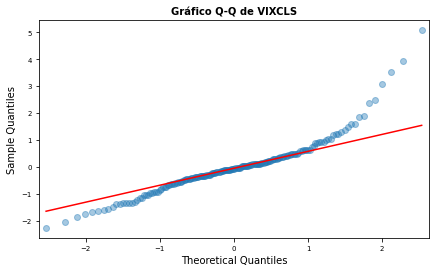

In [31]:
# Gráfico Q-Q
# ==============================================================================
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    X_train_ARIMA['VIXCLS'],
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de VIXCLS', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)



shapiro_test = stats.shapiro(X_train_ARIMA['VIXCLS'] )
print(shapiro_test)

k2, p_value = stats.normaltest(X_train_ARIMA['VIXCLS'])
print(f"Estadístico = {k2}, p-value = {p_value}")

## Análisis de heterocedasticidad en las variables 

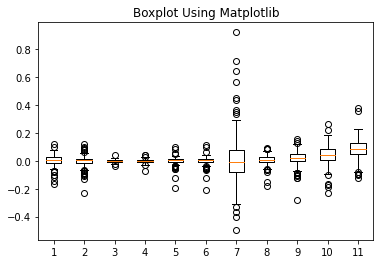

In [32]:
plt.boxplot(X)
plt.title("Boxplot Using Matplotlib")
plt.show()

In [33]:
levene_test = stats.levene(X_train_ARIMA['VIXCLS'], X_train_ARIMA['GOOGL'],X_train_ARIMA['DEXJPUS'],X_train_ARIMA['SP500'],X_train_ARIMA['DJIA'],X_train_ARIMA['VIXCLS'], center='median')
levene_test

LeveneResult(statistic=83.69475269211316, pvalue=4.603520630814976e-74)

Ahora configuramos un modelo Arima con orden (1,0,0)

In [34]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [35]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0010392113421478677


Ajustamos y podemos observar que el error se considera un error tolerante para poder aplicar el modelo ARIMA.

**LSTM Model**

Preparamos el modelo LSTM 

In [36]:
seq_len = 2 
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [37]:

def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

Visualización para ver si el error se reduce en el modelo lstm

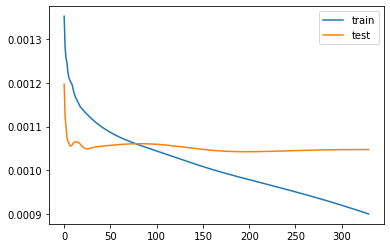

In [38]:

pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

**Añadimos todos los resultados**

Para comparar todos los modelos añadimos la comparación de los modelos base de series de tiempo a los modelos de machine learning 

In [40]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

**Comparación general de todos los algoritmos (incluidos los algoritmos base de series temporales)**

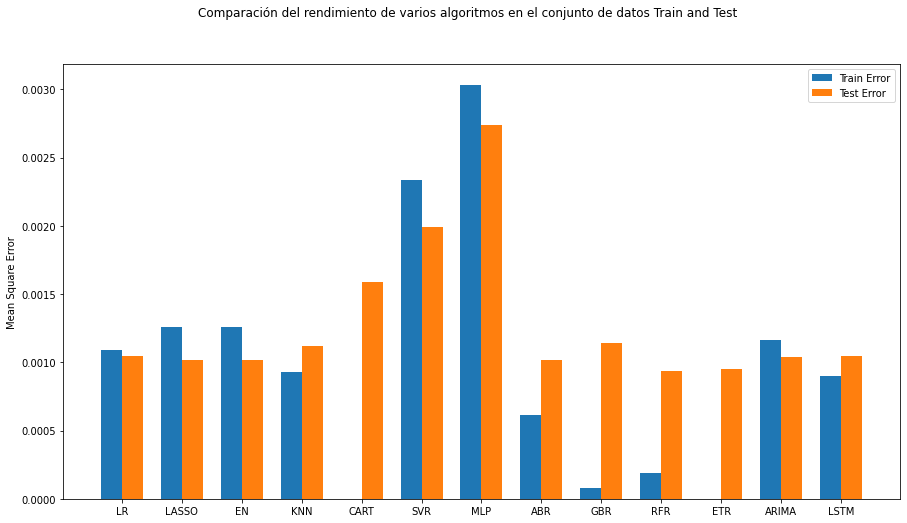

In [41]:

fig = pyplot.figure()

ind = np.arange(len(names))  
width = 0.35  

fig.suptitle('Comparación del rendimiento de varios algoritmos en el conjunto de datos Train and Test')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

En esta vista podemos observar que el modelo Arima y el modelo LR son los de mejor rendimiento. 

**Ajuste de modelo**

Como se muestra en el gráfico anterior, el modelo ARIMA es uno de los mejores modos, por lo que realizamos el ajuste del modelo ARIMA. El orden predeterminado del modelo ARIMA es [1,0,0]. Realizamos una búsqueda con diferentes combinaciones p,d y q para econtrar modelo ARIMA el orden apropiado.

In [42]:

def evaluate_arima_model(arima_order):
    predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 

def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0011737
ARIMA(0, 0, 1) MSE=0.0011525
ARIMA(0, 1, 0) MSE=0.0021937
ARIMA(0, 1, 1) MSE=0.0011978
ARIMA(1, 0, 0) MSE=0.0011601
ARIMA(1, 0, 1) MSE=0.0011353
ARIMA(1, 1, 0) MSE=0.0018136
ARIMA(1, 1, 1) MSE=0.0012095
ARIMA(2, 0, 0) MSE=0.0011497
ARIMA(2, 0, 1) MSE=0.0011494
ARIMA(2, 1, 0) MSE=0.0015765
ARIMA(2, 1, 1) MSE=0.0012024
Best ARIMA(1, 0, 1) MSE=0.0011353


**Finalizamos el modelo**

Preparamos el modelo Arima con los parámetros adecuados

In [43]:

modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

Generamos el error cuadrático medio el cual es aceptable.

In [44]:

predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0010392113421478677


    Visualizamos la comparación del precio real con la predicción

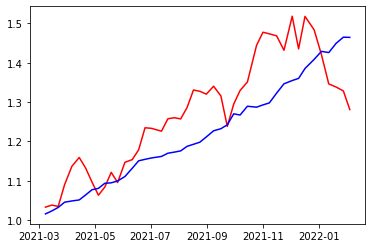

In [45]:
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') 
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

# Conclusiones


Podemos concluir que los modelos simples (regresión lineal, regresión regularizada (es decir, Lasso y red elástica)) junto con el modelo de serie temporal como ARIMA son enfoques de modelado prometedores para el problema de predicción de precios de activos. Estos modelos pueden permitir a los análistas financieros poder modelar modelar dependencias de tiempo con un enfoque muy flexible. El enfoque  presentado en este analisis  puede ayudarnos a encontrar el sobreajuste y el desajuste, que son algunos de los desafíos clave en el problema de la predicción en las finanzas. También debemos tener en cuenta que podemos usar un mejor conjunto historico de datos de indicadores, como la relación P/E, el volumen de negociación, los indicadores técnicos o los datos de noticias, lo que podría conducir a mejores resultados. En general, un modelado de series de tiempo y regresión supervisada nos permite realizar predicciones de clases de activos utilizando datos históricos para generar resultados y analizar el riesgo y la rentabilidad.